#Вопросы по теоретической части вебинара 3:
#1. Для чего и в каких случаях полезны различные варианты усреднения для метрик качества классификации: micro, macro, weighted?


макро метрика посчитает метрику независимо для каждого класса с последующим усреднением, не учитывается пропорция классов (в случае сбалансированных метрик, т.к. меньшая вычислительная нагрузка)

микро метрика собирает вклад каждой класса для вычисления среднего, учитывает TP, FN, FP итого (корректнее применять для несбалансированных классов)

взвешенная метрика считает метрику независимо для каждого класса с последующией корректировкой в зависимости от размера класса (специфичных задач конкретно под эту метрику не могу привести)

# 2. В чём разница между моделями xgboost, lightgbm и catboost или какие их основные особенности?

|  |  XGBoost | LightGBM |Catboost |
|------|--------|------|--------|
|поиск разбивки:|пред-сортировка на базе гистограм|goss односторонняя разбивка по градиенту|жадный алгоритм с перестановками и ограни макс размера|
|область применения:|стандарт|для драфтовых моделей|для множества категориальных признаков|
|скорость:|медленный|быстрый|средний|


дз я начал как исследование работы с несбалансированными классами - взял датасет churn (клиентооборот у телко компании, по объектам признаков - хар-ки клиента, по таргету - ушел /нет)

применил 3 метода: увеличение малого класса, уменьшение большего класса, синтечиское увеличнеие малого класса через бибилотеку SMOTE (базируется на ближ соседях с применением метрики по евклид расстоянию)

далее столкнулся с проблемой, на которой потерял много времени - нормализовать до или после обработки несбалансированности (по результату - до, хотя в коде обратная очередность, но потом я склеил выборки) и нужно ли балансировать всю выборку, или только трейн. 

после чего, по хорошему, все это надо проверить через модель на сетке с поиском гиперпараметров, но не хватило времени. поэтому закинул исходную и даже ненормализованную выборку в классификаторы, по итогу лучше всего (традиционно по моему опыту) отработал xgboost

ну опять таки, я все таки кодировал категорийные - возможно, катбуст отработал бы лучше.

из планов проверишь ошибку на разных моделях классификаторах на следующих состояниях:
- инфлированная выборка (исходная / скалированная / нормализованная)
- дефлированная выборка (исходная / скалированная / нормализованная)
- искусственно инфлированная (исходная / скалированная / нормализованная)

In [0]:
!pip install catboost

     |████████████████████████████████| 63.0MB 129kB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew, shapiro, normaltest

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, precision_score, auc, roc_auc_score

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE

from IPython.display import Image

from google.colab import drive

import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostClassifier

## functions

In [0]:
# significance level 5%
alpha = 0.05

def analyze(data):
    plt.style.use('ggplot')
    plt.hist(data, bins=60)
    plt.pause(0.1)
    print(f'mean: {np.mean(data)}')
    print(f'var: {np.var(data)}')
    print(f'skew: {skew(data)}')
    print(f'kurtosis: {kurtosis(data)}')
    print(f'shapiro: {shapiro(data)}')
    shapiro_stat, shapiro_p = shapiro(data)
    if shapiro_p > alpha:
        print('according to shapiro test looks like gaussian')
    else:
        print('according to shapiro test doesnt look like gaussian')
    print(f'normal_test: {normaltest(data)}')
    norm_stat, norm_p = normaltest(data)
    if norm_p > alpha:
        print('according to k2 test looks like gaussian')
    else:
        print('according to k2 test doesnt look like gaussian')
    print('*'*20)

# binary classification metrics 
def value_of_metrics(y_true, y_pred):
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('recall: ', recall_score(y_true, y_pred))
    print('precision: ', precision_score(y_true, y_pred))
    print('f1: ', f1_score(y_true, y_pred))
    print('roc_auc: ', roc_auc_score(y_true, y_pred))

    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('my_dataset')
    plt.plot(fpr, tpr, 'b', label='auc=%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('true poistive rate')
    plt.xlabel('false positive rate')
    plt.show()

## data upload

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp 'drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!kaggle datasets download -d becksddf/churn-in-telecoms-dataset
!unzip churn-in-telecoms-dataset.zip
!ls

  0% 0.00/116k [00:00<?, ?B/s]
100% 116k/116k [00:00<00:00, 103MB/s]
Archive:  churn-in-telecoms-dataset.zip
  inflating: bigml_59c28831336c6604c800002a.csv  
bigml_59c28831336c6604c800002a.csv  drive
churn-in-telecoms-dataset.zip	    sample_data


In [0]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

## features preprocessing

#### general analysis

In [0]:
print(df.shape)
print(df.columns)
df.head(3)

(3333, 21)
Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [0]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [0]:
# extending the number of columns and rows
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# setting the decimal format
pd.set_option('precision', 2)

In [0]:
# converting target from churn to int
df['churn'] = df['churn'].astype('int64')

In [0]:
df.describe(include=['object', 'bool'])

,state,phone number,international plan,voice mail plan
count,3333,3333,3333,3333
unique,51,3333,2,2
top,WV,384-5335,no,no
freq,106,1,3010,2411


In [0]:
df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [0]:
df['area code'].value_counts(normalize=True)

415    0.50
510    0.25
408    0.25
Name: area code, dtype: float64

In [0]:
df.sort_values(by='total day charge', ascending=False).head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
365,CO,154,415,343-5709,no,no,0,350.8,75,59.64,216.5,94,18.40,253.9,100,11.43,10.1,9,2.73,1,1
985,NY,64,415,345-9140,yes,no,0,346.8,55,58.96,249.5,79,21.21,275.4,102,12.39,13.3,9,3.59,1,1
2594,OH,115,510,348-1163,yes,no,0,345.3,81,58.70,203.4,106,17.29,217.5,107,9.79,11.8,8,3.19,1,1
156,OH,83,415,370-9116,no,no,0,337.4,120,57.36,227.4,116,19.33,153.9,114,6.93,15.8,7,4.27,0,1
605,MO,112,415,373-2053,no,no,0,335.5,77,57.04,212.5,109,18.06,265.0,132,11.93,12.7,8,3.43,2,1


In [0]:
df.sort_values(by=['churn', 'total day charge'], ascending=[True, False]).head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
688,MN,13,510,338-7120,no,yes,21,315.6,105,53.65,208.9,71,17.76,260.1,123,11.70,12.1,3,3.27,3,0
2259,NC,210,415,363-7802,no,yes,31,313.8,87,53.35,147.7,103,12.55,192.7,97,8.67,10.1,7,2.73,3,0
534,LA,67,510,373-6784,no,no,0,310.4,97,52.77,66.5,123,5.65,246.5,99,11.09,9.2,10,2.48,4,0
575,SD,114,415,351-7369,no,yes,36,309.9,90,52.68,200.3,89,17.03,183.5,105,8.26,14.2,2,3.83,1,0
2858,AL,141,510,388-8583,no,yes,28,308.0,123,52.36,247.8,128,21.06,152.9,103,6.88,7.4,3,2.00,1,0


In [0]:
df[df['churn'] == 1].mean()

account length            102.66
area code                 437.82
number vmail messages       5.12
total day minutes         206.91
total day calls           101.34
total day charge           35.18
total eve minutes         212.41
total eve calls           100.56
total eve charge           18.05
total night minutes       205.23
total night calls         100.40
total night charge          9.24
total intl minutes         10.70
total intl calls            4.16
total intl charge           2.89
customer service calls      2.23
churn                       1.00
dtype: float64

In [0]:
df[df['churn'] == 0].mean()

account length            100.79
area code                 437.07
number vmail messages       8.60
total day minutes         175.18
total day calls           100.28
total day charge           29.78
total eve minutes         199.04
total eve calls           100.04
total eve charge           16.92
total night minutes       200.13
total night calls         100.06
total night charge          9.01
total intl minutes         10.16
total intl calls            4.53
total intl charge           2.74
customer service calls      1.45
churn                       0.00
dtype: float64

In [0]:
print(df[(df['churn'] == 0) & (df['international plan'] == 'no')]['total intl minutes'].max())
print(df[(df['churn'] == 1) & (df['international plan'] == 'no')]['total intl minutes'].max())
print(df[(df['churn'] == 0) & (df['international plan'] == 'yes')]['total intl minutes'].max())
print(df[(df['churn'] == 1) & (df['international plan'] == 'yes')]['total intl minutes'].max())

18.9
18.3
13.0
20.0


In [0]:
df.apply(np.max) 

state                           WY
account length                 243
area code                      510
phone number              422-9964
international plan             yes
voice mail plan                yes
number vmail messages           51
total day minutes          3.5e+02
total day calls                165
total day charge                60
total eve minutes          3.6e+02
total eve calls                170
total eve charge                31
total night minutes          4e+02
total night calls              175
total night charge              18
total intl minutes              20
total intl calls                20
total intl charge              5.4
customer service calls           9
churn                            1
dtype: object

In [0]:
df[df['state'].apply(lambda state: state[0] == 'W')].head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0
26,WY,57,408,357-3817,no,yes,39,213.0,115,36.21,191.1,112,16.24,182.7,115,8.22,9.5,3,2.57,0,0
44,WI,64,510,352-1237,no,no,0,154.0,67,26.18,225.8,118,19.19,265.3,86,11.94,3.5,3,0.95,1,0
49,WY,97,415,405-7146,no,yes,24,133.2,135,22.64,217.2,58,18.46,70.6,79,3.18,11.0,3,2.97,1,0
54,WY,87,415,353-3759,no,no,0,151.0,83,25.67,219.7,116,18.67,203.9,127,9.18,9.7,3,2.62,5,1


In [0]:
temp = {'no': False, 'yes' : True}
df['international plan'] = df['international plan'].map(temp)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,False,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,False,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,False,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,True,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,True,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [0]:
df = df.replace({'voice mail plan': temp})
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [0]:
columns_to_show = ['total day minutes', 'total eve minutes', 'total night minutes']
df.groupby(['churn'])[columns_to_show].describe(percentiles=[])

total day minutes                                   total eve minutes  \
                  count    mean    std  min    50%    max             count   
churn                                                                         
0                2850.0  175.18  50.18  0.0  177.2  315.6            2850.0   
1                 483.0  206.91  69.00  0.0  217.6  350.8             483.0   

                                         total night minutes                 \
         mean    std   min    50%    max               count    mean    std   
churn                                                                         
0      199.04  50.29   0.0  199.6  361.8              2850.0  200.13  51.11   
1      212.41  51.73  70.9  211.3  363.7               483.0  205.23  47.13   

                            
        min     50%    max  
churn                       
0      23.2  200.25  395.0  
1      47.4  204.80  354.9

In [0]:
df.groupby(['churn'])[columns_to_show].agg([np.mean, np.std, np.min, np.max])

total day minutes                    total eve minutes               \
                   mean    std amin   amax              mean    std  amin   
churn                                                                       
0                175.18  50.18  0.0  315.6            199.04  50.29   0.0   
1                206.91  69.00  0.0  350.8            212.41  51.73  70.9   

             total night minutes                      
        amax                mean    std  amin   amax  
churn                                                 
0      361.8              200.13  51.11  23.2  395.0  
1      363.7              205.23  47.13  47.4  354.9

In [0]:
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

#### processing categorical features

In [0]:
state_dum = pd.get_dummies(df['state'], prefix='state_', dummy_na=False)
area_code_dum = pd.get_dummies(df['area code'], prefix='area_code_', dummy_na=False)

In [0]:
df = pd.concat([df, state_dum, area_code_dum], axis=1)

In [0]:
df.drop(columns=['state', 'area code', 'phone number'], inplace=True)
df.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,state__AK,state__AL,state__AR,state__AZ,state__CA,state__CO,state__CT,state__DC,state__DE,state__FL,state__GA,state__HI,state__IA,state__ID,state__IL,state__IN,state__KS,state__KY,state__LA,state__MA,state__MD,state__ME,state__MI,state__MN,state__MO,state__MS,state__MT,state__NC,state__ND,state__NE,state__NH,state__NJ,state__NM,state__NV,state__NY,state__OH,state__OK,state__OR,state__PA,state__RI,state__SC,state__SD,state__TN,state__TX,state__UT,state__VA,state__VT,state__WA,state__WI,state__WV,state__WY,area_code__408,area_code__415,area_code__510
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 72 columns):
account length            3333 non-null int64
international plan        3333 non-null bool
voice mail plan           3333 non-null bool
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
churn                     3333 non-null int64
state__AK                 3333 non-null uint8
state

#### train test split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='churn', axis=1),
                                                    df.churn,
                                                    test_size=0.25,
                                                    random_state=42)

#### processing the unbalanced classes

In [0]:
print(y_train.value_counts())
print(y_test.value_counts())

0    2141
1     358
Name: churn, dtype: int64
0    709
1    125
Name: churn, dtype: int64


In [0]:
x_train.columns

Index(['account length', 'international plan', 'voice mail plan',
       'number vmail messages', 'total day minutes', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night minutes', 'total night calls',
       'total night charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'state__AK', 'state__AL',
       'state__AR', 'state__AZ', 'state__CA', 'state__CO', 'state__CT',
       'state__DC', 'state__DE', 'state__FL', 'state__GA', 'state__HI',
       'state__IA', 'state__ID', 'state__IL', 'state__IN', 'state__KS',
       'state__KY', 'state__LA', 'state__MA', 'state__MD', 'state__ME',
       'state__MI', 'state__MN', 'state__MO', 'state__MS', 'state__MT',
       'state__NC', 'state__ND', 'state__NE', 'state__NH', 'state__NJ',
       'state__NM', 'state__NV', 'state__NY', 'state__OH', 'state__OK',
       'state__OR', 'state__PA', 'state__RI', 'state__SC', 'state__SD

In [0]:
pd.concat([x_train, y_train], axis=1)['churn'].value_counts()

0    2141
1     358
Name: churn, dtype: int64

In [0]:
# separating the classes within the target sample for the train sample

cl0 = pd.concat([x_train, y_train], axis=1)[pd.concat([x_train, y_train], axis=1)['churn']== 0]
cl1 = pd.concat([x_train, y_train], axis=1)[pd.concat([x_train, y_train], axis=1)['churn']== 1]

##### increasing minority class

In [0]:
# upsampling the minority class
cl1_up = resample(cl1,
                  replace=True,
                  n_samples=len(cl0),
                  random_state=42
)

# concating the upsampled & majority class
df_infl = pd.concat([cl0, cl1_up])

print(df_infl.churn.value_counts())

1    2141
0    2141
Name: churn, dtype: int64


##### decreasing majority class

In [0]:
# downsampling the majority class
cl0_down = resample(cl0,
                    replace=False,
                    n_samples = len(cl1),
                    random_state=42
)

# concating the downsampled & minority class
df_defl = pd.concat([cl0_down, cl1])

print(df_defl.churn.value_counts())

1    358
0    358
Name: churn, dtype: int64


##### synthetic increase of minority class

In [0]:
sm = SMOTE(random_state=42, ratio=1.0)
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

print(np.unique(y_train_sm, return_counts=True))

(array([0, 1]), array([2141, 2141]))


#### checking the proximity to the normal distribution

In [0]:
pd.concat([x_train, x_test], axis=0)

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state__AK,state__AL,state__AR,state__AZ,state__CA,state__CO,state__CT,state__DC,state__DE,state__FL,state__GA,state__HI,state__IA,state__ID,state__IL,state__IN,state__KS,state__KY,state__LA,state__MA,state__MD,state__ME,state__MI,state__MN,state__MO,state__MS,state__MT,state__NC,state__ND,state__NE,state__NH,state__NJ,state__NM,state__NV,state__NY,state__OH,state__OK,state__OR,state__PA,state__RI,state__SC,state__SD,state__TN,state__TX,state__UT,state__VA,state__VT,state__WA,state__WI,state__WV,state__WY,area_code__408,area_code__415,area_code__510
367,45,False,False,0,78.2,127,13.29,253.4,108,21.54,255.0,100,11.48,18.0,3,4.86,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3103,115,False,False,0,195.9,111,33.30,227.0,108,19.30,313.2,113,14.09,13.2,1,3.56,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
549,121,False,True,31,237.1,63,40.31,205.6,117,17.48,196.7,85,8.85,10.1,5,2.73,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2531,180,False,False,0,143.3,134,24.36,180.5,113,15.34,184.2,87,8.29,10.1,4,2.73,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2378,112,False,False,0,206.2,122,35.05,164.5,94,13.98,140.3,101,6.31,12.6,7,3.40,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,171,False,False,0,137.5,110,23.38,198.1,109,16.84,292.7,131,13.17,13.3,5,3.59,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1586,89,False,False,0,82.3,77,13.99,167.2,80,14.21,194.7,70,8.76,7.2,4,1.94,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3068,78,False,True,21,160.6,85,27.30,223.1,79,18.96,124.0,92,5.58,9.5,1,2.57,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2484,141,False,True,39,116.9,127,19.87,276.5,88,23.50,289.9,125,13.05,12.3,2,3.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


account length :



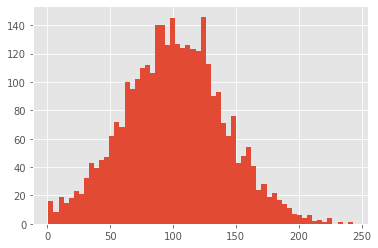

mean: 101.06480648064806
var: 1585.324332973352
skew: 0.09656281161489656
kurtosis: -0.10947391843415843
shapiro: (0.9982772469520569, 0.0011495520593598485)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=6.884425983113991, pvalue=0.03199380490776518)
according to k2 test doesnt look like gaussian
********************
number vmail messages :



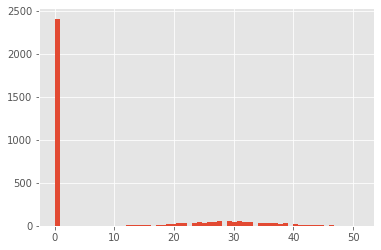

mean: 8.099009900990099
var: 187.31512953276214
skew: 1.2642543349768245
kurtosis: -0.05285151059052451
shapiro: (0.6219369769096375, 0.0)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=556.3629445342845, pvalue=1.5392941776140257e-121)
according to k2 test doesnt look like gaussian
********************
total day minutes :



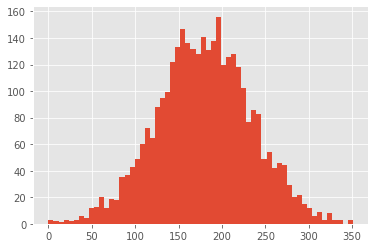

mean: 179.77509750975113
var: 2965.8063885668507
skew: -0.029063979518119776
kurtosis: -0.021710117924088834
shapiro: (0.9995365738868713, 0.6374387741088867)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.5096211575886949, pvalue=0.7750632974814369)
according to k2 test looks like gaussian
********************
total day calls :



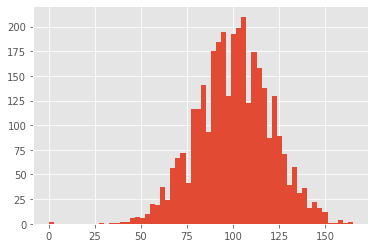

mean: 100.43564356435644
var: 402.64729839320466
skew: -0.11173632373075187
kurtosis: 0.24101722895174227
shapiro: (0.9979861974716187, 0.0002773392479866743)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=13.751527379983745, pvalue=0.0010325088208268521)
according to k2 test doesnt look like gaussian
********************
total day charge :



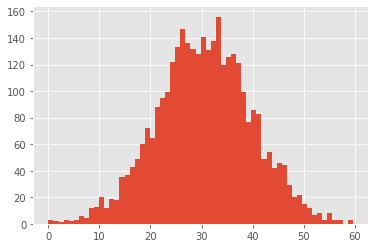

mean: 30.562307230723032
var: 85.71140454767365
skew: -0.02907017792703772
kurtosis: -0.021581719145034928
shapiro: (0.9995384216308594, 0.641385018825531)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.5092159606353168, pvalue=0.7752203400325979)
according to k2 test looks like gaussian
********************
total eve minutes :



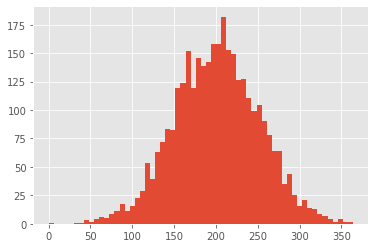

mean: 200.98034803480277
var: 2571.1223710759878
skew: -0.023866708804637538
kurtosis: 0.023791680444704255
shapiro: (0.9995718598365784, 0.711155354976654)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.4342080446809039, pvalue=0.804846242960475)
according to k2 test looks like gaussian
********************
total eve calls :



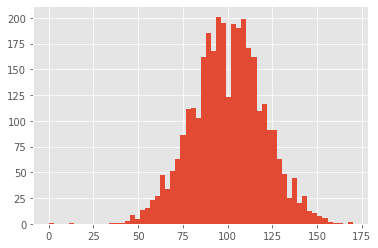

mean: 100.11431143114311
var: 396.7919133947589
skew: -0.055538130001619244
kurtosis: 0.20404769217448315
shapiro: (0.9986738562583923, 0.00886891596019268)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=6.811357530792207, pvalue=0.033184288089437956)
according to k2 test doesnt look like gaussian
********************
total eve charge :



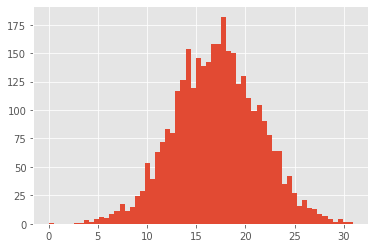

mean: 17.0835403540354
var: 18.576280415188236
skew: -0.023847250496276947
kurtosis: 0.02364954586272594
shapiro: (0.9995685815811157, 0.7044191360473633)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.4325726682331947, pvalue=0.8055046253944554)
according to k2 test looks like gaussian
********************
total night minutes :



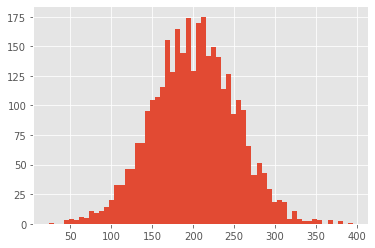

mean: 200.87203720372017
var: 2556.9466108212987
skew: 0.008917275580987899
kurtosis: 0.08388775499253409
shapiro: (0.9995295405387878, 0.6227363348007202)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.0757351051449517, pvalue=0.5839922583028712)
according to k2 test looks like gaussian
********************
total night calls :



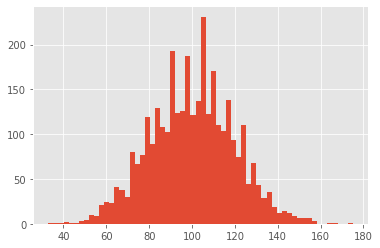

mean: 100.10771077107711
var: 382.8155811080672
skew: 0.032484942054044605
kurtosis: -0.07371122421258969
shapiro: (0.9993115067481995, 0.25032323598861694)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.296432518261505, pvalue=0.5229778021474079)
according to k2 test looks like gaussian
********************
total night charge :



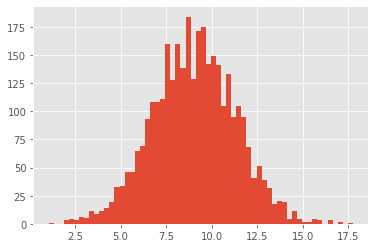

mean: 9.039324932493257
var: 5.178043138643314
skew: 0.008882237062694438
kurtosis: 0.08373508611499947
shapiro: (0.9995283484458923, 0.6202784180641174)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.0720084566277213, pvalue=0.5850814396785157)
according to k2 test looks like gaussian
********************
total intl minutes :



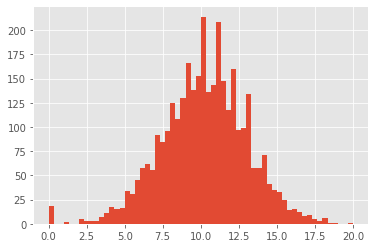

mean: 10.237293729372958
var: 7.792029519783703
skew: -0.24502560348664437
kurtosis: 0.6064716354043189
shapiro: (0.9937329888343811, 8.136633727895415e-11)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=64.21001941586228, pvalue=1.1401748114018812e-14)
according to k2 test doesnt look like gaussian
********************
total intl calls :



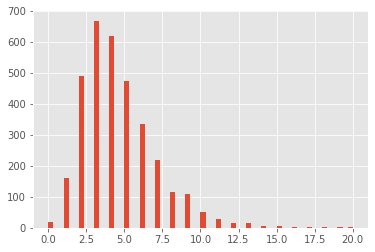

mean: 4.4794479447944795
var: 6.055758231088596
skew: 1.320883366816401
kurtosis: 3.0771654389888496
shapiro: (0.9057914018630981, 2.583573978675665e-41)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=835.9852267335729, pvalue=2.9384245140173755e-182)
according to k2 test doesnt look like gaussian
********************
total intl charge :



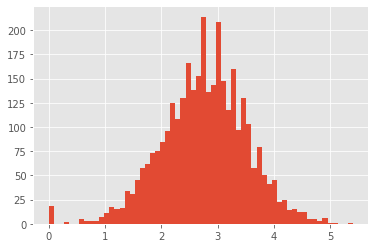

mean: 2.764581458145801
var: 0.5680026826084922
skew: -0.2451761045009843
kurtosis: 0.606896666652768
shapiro: (0.9937072992324829, 7.591647449567418e-11)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=64.28330348321433, pvalue=1.0991526450917064e-14)
according to k2 test doesnt look like gaussian
********************
customer service calls :



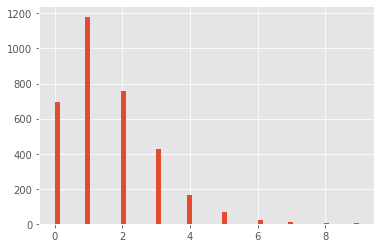

mean: 1.5628562856285628
var: 1.729997482196488
skew: 1.090868260175501
kurtosis: 1.7265184753957081
shapiro: (0.8767161965370178, 1.401298464324817e-45)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=584.1773154131287, pvalue=1.404454686107752e-127)
according to k2 test doesnt look like gaussian
********************


In [0]:
for i in list(pd.concat([x_train, x_test], axis=0).select_dtypes(exclude=['bool', 'uint8'])):
    print(i,':\n')
    analyze(pd.concat([x_train, x_test], axis=0)[i])

#### normalizing features via PowerTransformer

In [0]:
yeo_johnson_transform = PowerTransformer(method='yeo-johnson', standardize=False)

to_be_normalized = ['account length', 'number vmail messages', 'total day calls', 'total eve calls',
                    'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']

x_norm = pd.concat([x_train, x_test], axis=0)
for i in to_be_normalized:
    x_norm[f'norm_{i}'] = yeo_johnson_transform.fit_transform(
        pd.concat([x_train, x_test], axis=0)[i].values.reshape(pd.concat([x_train, x_test], axis=0).shape[0], -1)
    )
x_norm.drop(columns=to_be_normalized, axis=1, inplace=True) 

total day minutes


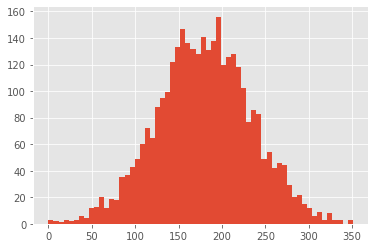

mean: 179.77509750975113
var: 2965.8063885668507
skew: -0.029063979518119776
kurtosis: -0.021710117924088834
shapiro: (0.9995365738868713, 0.6374387741088867)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.5096211575886949, pvalue=0.7750632974814369)
according to k2 test looks like gaussian
********************
total day charge


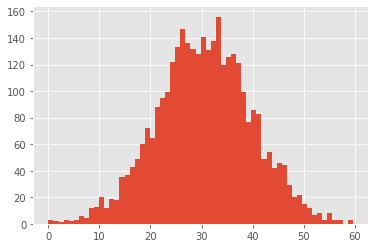

mean: 30.562307230723032
var: 85.71140454767365
skew: -0.02907017792703772
kurtosis: -0.021581719145034928
shapiro: (0.9995384216308594, 0.641385018825531)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.5092159606353168, pvalue=0.7752203400325979)
according to k2 test looks like gaussian
********************
total eve minutes


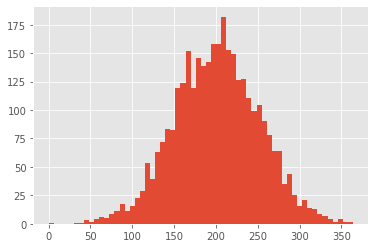

mean: 200.98034803480277
var: 2571.1223710759878
skew: -0.023866708804637538
kurtosis: 0.023791680444704255
shapiro: (0.9995718598365784, 0.711155354976654)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.4342080446809039, pvalue=0.804846242960475)
according to k2 test looks like gaussian
********************
total eve charge


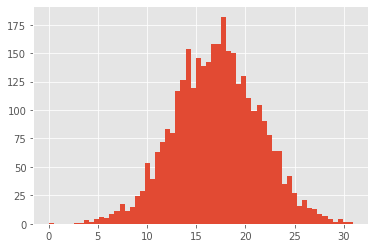

mean: 17.0835403540354
var: 18.576280415188236
skew: -0.023847250496276947
kurtosis: 0.02364954586272594
shapiro: (0.9995685815811157, 0.7044191360473633)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.4325726682331947, pvalue=0.8055046253944554)
according to k2 test looks like gaussian
********************
total night minutes


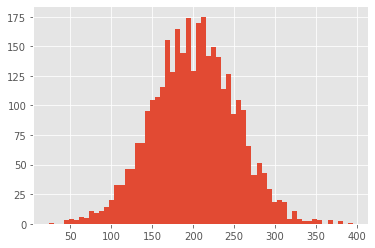

mean: 200.87203720372017
var: 2556.9466108212987
skew: 0.008917275580987899
kurtosis: 0.08388775499253409
shapiro: (0.9995295405387878, 0.6227363348007202)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.0757351051449517, pvalue=0.5839922583028712)
according to k2 test looks like gaussian
********************
total night calls


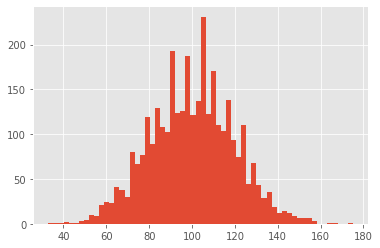

mean: 100.10771077107711
var: 382.8155811080672
skew: 0.032484942054044605
kurtosis: -0.07371122421258969
shapiro: (0.9993115067481995, 0.25032323598861694)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.296432518261505, pvalue=0.5229778021474079)
according to k2 test looks like gaussian
********************
total night charge


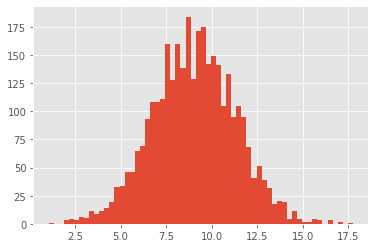

mean: 9.039324932493257
var: 5.178043138643314
skew: 0.008882237062694438
kurtosis: 0.08373508611499947
shapiro: (0.9995283484458923, 0.6202784180641174)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.0720084566277213, pvalue=0.5850814396785157)
according to k2 test looks like gaussian
********************
norm_account length


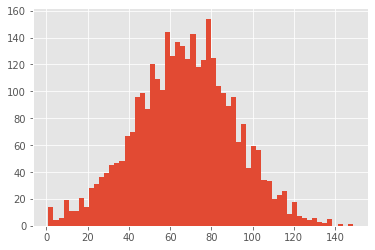

mean: 67.25930346903067
var: 584.2326694860483
skew: -0.04471560745412732
kurtosis: -0.07976388853085759
shapiro: (0.9988489151000977, 0.02251579612493515)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=1.9587093739236123, pvalue=0.3755533701588767)
according to k2 test looks like gaussian
********************
norm_number vmail messages


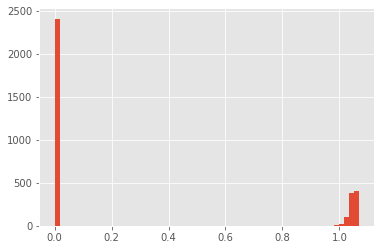

mean: 0.2894754506288256
var: 0.21919760527065874
skew: 0.9997749963910223
kurtosis: -0.9989466340048279
shapiro: (0.5646040439605713, 0.0)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=1141.287471120958, pvalue=1.4879026368481617e-248)
according to k2 test doesnt look like gaussian
********************
norm_total day calls


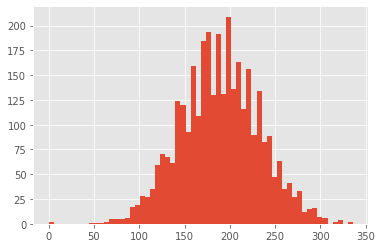

mean: 189.17439456141489
var: 1895.8295581210944
skew: 0.011537036708500798
kurtosis: 0.07422258101462242
shapiro: (0.999080240726471, 0.07731838524341583)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.9018106486594734, pvalue=0.6370511525678355)
according to k2 test looks like gaussian
********************
norm_total eve calls


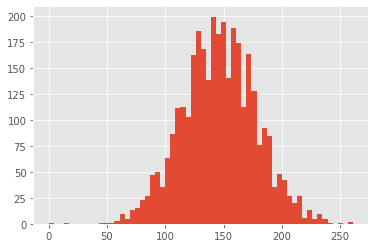

mean: 146.1645012366656
var: 1008.938021208298
skew: 0.016779866366443116
kurtosis: 0.1311233962347611
shapiro: (0.999043345451355, 0.06359927356243134)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=2.466083925418509, pvalue=0.29140478555922744)
according to k2 test looks like gaussian
********************
norm_total intl minutes


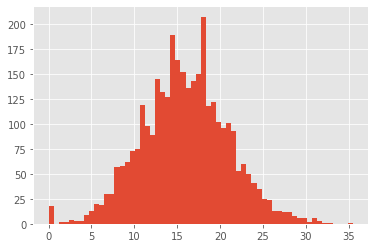

mean: 15.932810808746392
var: 25.79685039148048
skew: 0.024349340796518543
kurtosis: 0.27654540905417013
shapiro: (0.9980970025062561, 0.00047266166075132787)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=9.004275650681333, pvalue=0.011085272811560886)
according to k2 test doesnt look like gaussian
********************
norm_total intl calls


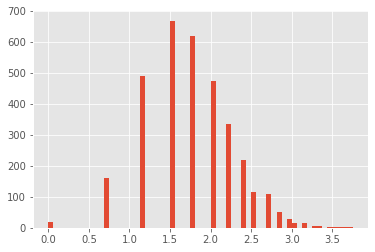

mean: 1.8058379976146421
var: 0.29588779395014686
skew: 0.005813718290613373
kurtosis: 0.2850791014606573
shapiro: (0.975574254989624, 1.7762066294881393e-23)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=9.159861339552615, pvalue=0.010255607295304768)
according to k2 test doesnt look like gaussian
********************
norm_total intl charge


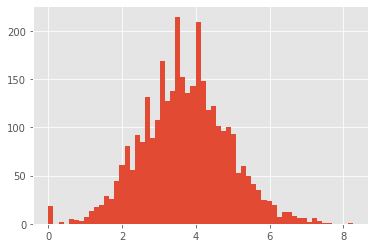

mean: 3.712924215306476
var: 1.3725455413475982
skew: 0.03161423235104621
kurtosis: 0.3096421362507371
shapiro: (0.9978334307670593, 0.00013513004523701966)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=11.092774482553715, pvalue=0.0039015270887180794)
according to k2 test doesnt look like gaussian
********************
norm_customer service calls


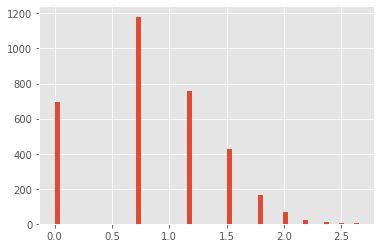

mean: 0.870328857887891
var: 0.3273594977618635
skew: -0.013763605949336876
kurtosis: -0.6285892573322243
shapiro: (0.9090682864189148, 8.858728631768629e-41)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=123.06264370193546, pvalue=1.893592199622233e-27)
according to k2 test doesnt look like gaussian
********************


In [0]:
for i in list(x_norm.select_dtypes(exclude=['bool', 'uint8'])):
    print(i)
    analyze(x_norm[i])

#### normalizing features via StandardScaler

In [0]:
scaler = StandardScaler()
x_scl = pd.concat([x_train, x_test], axis=0)
scaler.fit(x_scl.select_dtypes(include=['float']))

StandardScaler(copy=True, with_mean=True, with_std=True)

total day minutes


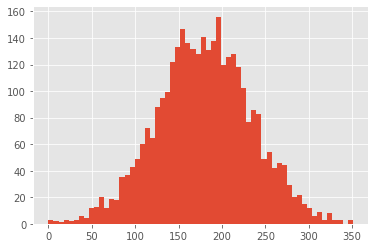

mean: 179.77509750975113
var: 2965.8063885668507
skew: -0.029063979518119776
kurtosis: -0.021710117924088834
shapiro: (0.9995365738868713, 0.6374387741088867)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.5096211575886949, pvalue=0.7750632974814369)
according to k2 test looks like gaussian
********************
total day charge


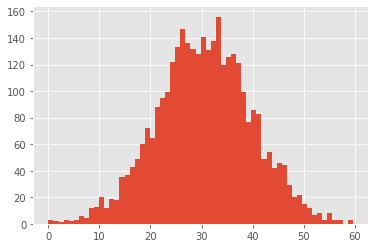

mean: 30.562307230723032
var: 85.71140454767365
skew: -0.02907017792703772
kurtosis: -0.021581719145034928
shapiro: (0.9995384216308594, 0.641385018825531)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.5092159606353168, pvalue=0.7752203400325979)
according to k2 test looks like gaussian
********************
total eve minutes


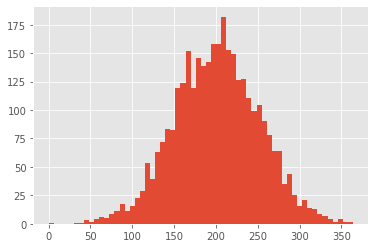

mean: 200.98034803480277
var: 2571.1223710759878
skew: -0.023866708804637538
kurtosis: 0.023791680444704255
shapiro: (0.9995718598365784, 0.711155354976654)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.4342080446809039, pvalue=0.804846242960475)
according to k2 test looks like gaussian
********************
total eve charge


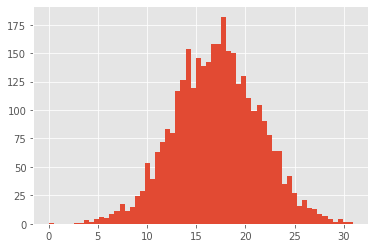

mean: 17.0835403540354
var: 18.576280415188236
skew: -0.023847250496276947
kurtosis: 0.02364954586272594
shapiro: (0.9995685815811157, 0.7044191360473633)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=0.4325726682331947, pvalue=0.8055046253944554)
according to k2 test looks like gaussian
********************
total night minutes


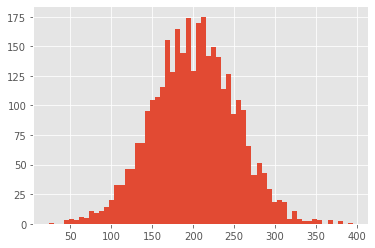

mean: 200.87203720372017
var: 2556.9466108212987
skew: 0.008917275580987899
kurtosis: 0.08388775499253409
shapiro: (0.9995295405387878, 0.6227363348007202)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.0757351051449517, pvalue=0.5839922583028712)
according to k2 test looks like gaussian
********************
total night charge


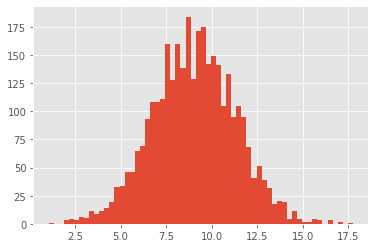

mean: 9.039324932493257
var: 5.178043138643314
skew: 0.008882237062694438
kurtosis: 0.08373508611499947
shapiro: (0.9995283484458923, 0.6202784180641174)
according to shapiro test looks like gaussian
normal_test: NormaltestResult(statistic=1.0720084566277213, pvalue=0.5850814396785157)
according to k2 test looks like gaussian
********************
total intl minutes


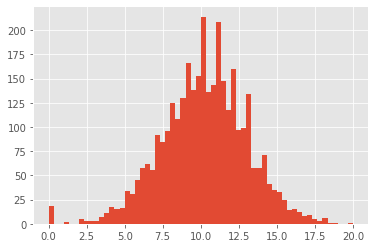

mean: 10.237293729372958
var: 7.792029519783703
skew: -0.24502560348664437
kurtosis: 0.6064716354043189
shapiro: (0.9937329888343811, 8.136633727895415e-11)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=64.21001941586228, pvalue=1.1401748114018812e-14)
according to k2 test doesnt look like gaussian
********************
total intl charge


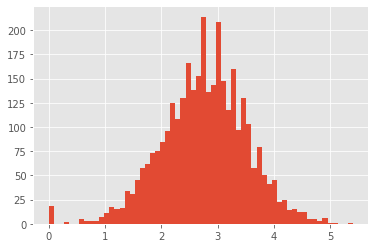

mean: 2.764581458145801
var: 0.5680026826084922
skew: -0.2451761045009843
kurtosis: 0.606896666652768
shapiro: (0.9937072992324829, 7.591647449567418e-11)
according to shapiro test doesnt look like gaussian
normal_test: NormaltestResult(statistic=64.28330348321433, pvalue=1.0991526450917064e-14)
according to k2 test doesnt look like gaussian
********************


In [0]:
for i in x_scl.select_dtypes(include=['float']):
    print(i)
    analyze(x_scl[i])

## build, fit & predict

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2499, 71)
(834, 71)
(2499,)
(834,)


### xgboost

In [0]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9484412470023981

### lightgbm

In [0]:
model = lgbm.LGBMClassifier()
model.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9460431654676259

### catbooster

In [0]:
model = CatBoostClassifier()
model.fit(x_train, y_train)

Learning rate set to 0.021712
0:	learn: 0.6683551	total: 52.6ms	remaining: 52.5s
1:	learn: 0.6510978	total: 55.8ms	remaining: 27.9s
2:	learn: 0.6314371	total: 59ms	remaining: 19.6s
3:	learn: 0.6125589	total: 62.3ms	remaining: 15.5s
4:	learn: 0.5919381	total: 65.4ms	remaining: 13s
5:	learn: 0.5782727	total: 69ms	remaining: 11.4s
6:	learn: 0.5637081	total: 72.4ms	remaining: 10.3s
7:	learn: 0.5471357	total: 75.8ms	remaining: 9.39s
8:	learn: 0.5293970	total: 79ms	remaining: 8.7s
9:	learn: 0.5166125	total: 82.3ms	remaining: 8.15s
10:	learn: 0.5065201	total: 85.5ms	remaining: 7.68s
11:	learn: 0.4947877	total: 88.8ms	remaining: 7.31s
12:	learn: 0.4802757	total: 92.1ms	remaining: 6.99s
13:	learn: 0.4685612	total: 95.2ms	remaining: 6.7s
14:	learn: 0.4587588	total: 99ms	remaining: 6.5s
15:	learn: 0.4455112	total: 102ms	remaining: 6.29s
16:	learn: 0.4320605	total: 106ms	remaining: 6.11s
17:	learn: 0.4253399	total: 109ms	remaining: 5.95s
18:	learn: 0.4133353	total: 112ms	remaining: 5.81s
19:	learn

In [0]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9520383693045563